<a href="https://colab.research.google.com/github/MilindMali0339/Epileptic-Seizure-Detection-using-ML/blob/main/Copy_of_new_dataset_fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

eeg = pd.read_csv('/content/seizure_kaggle.csv')

eeg.head()
eeg.info()

eeg_new = eeg.iloc[:100, :70]
eeg_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-61,-80,-77,-66,-43,5,87,129,121,88
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,-388,-679,-892,-949,-972,-1001,-1006,-949,-847,-668
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,-20,-48,-71,-71,-57,-32,-13,6,29,27
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-70,-50,-37,-31,-32,-39,-54,-64,-68,-67
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,-37,-22,5,30,31,6,-32,-27,-27,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


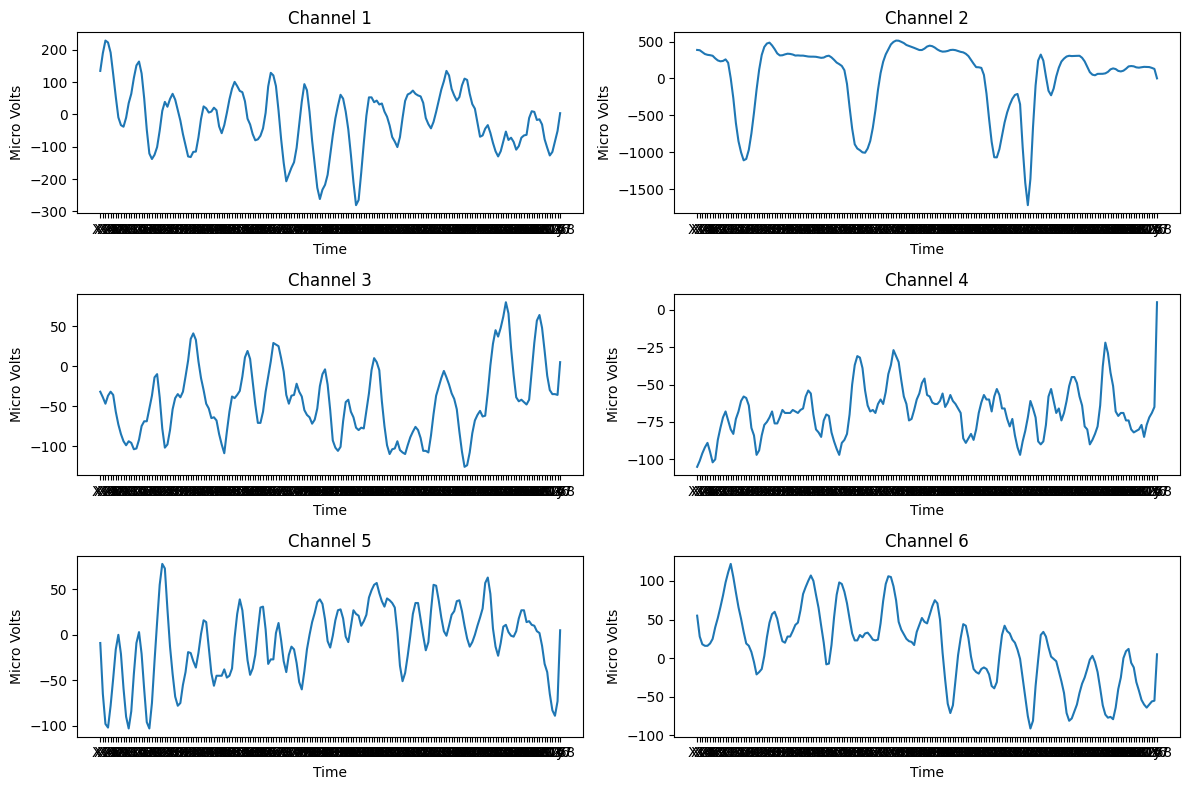

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

eeg = pd.read_csv('/content/seizure_kaggle.csv')

eeg.head()
eeg.info()

eeg_new = eeg.iloc[:100, :70]
eeg_new.head()

channels_to_plot = eeg.iloc[:6, 1:]  # Assuming the first column is not the time index

# Plot EEG data for each selected channel in separate subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns for 6 plots
axes = axes.flatten()  # Flatten the 2D array of axes

for i, ax in enumerate(axes):
    ax.plot(channels_to_plot.iloc[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Micro Volts')
    ax.set_title(f'Channel {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
!pip install scikit-fuzzy
#!pip install --upgrade scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=df4802e065ec284c844429a694a2e50e07127d0e418cc12649af888fd5cff34c
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


Data loading time: 0.4847750663757324 seconds
Data preprocessing time: 0.10724520683288574 seconds
Test Set Performance:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.93      1.00      0.97        28

    accuracy                           0.95        40
   macro avg       0.97      0.92      0.94        40
weighted avg       0.95      0.95      0.95        40

Confusion Matrix:
 Predicted   0   1
Actual           
0          10   2
1           0  28


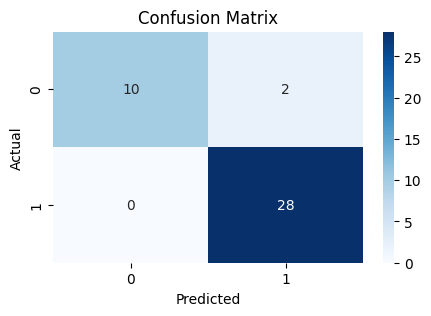

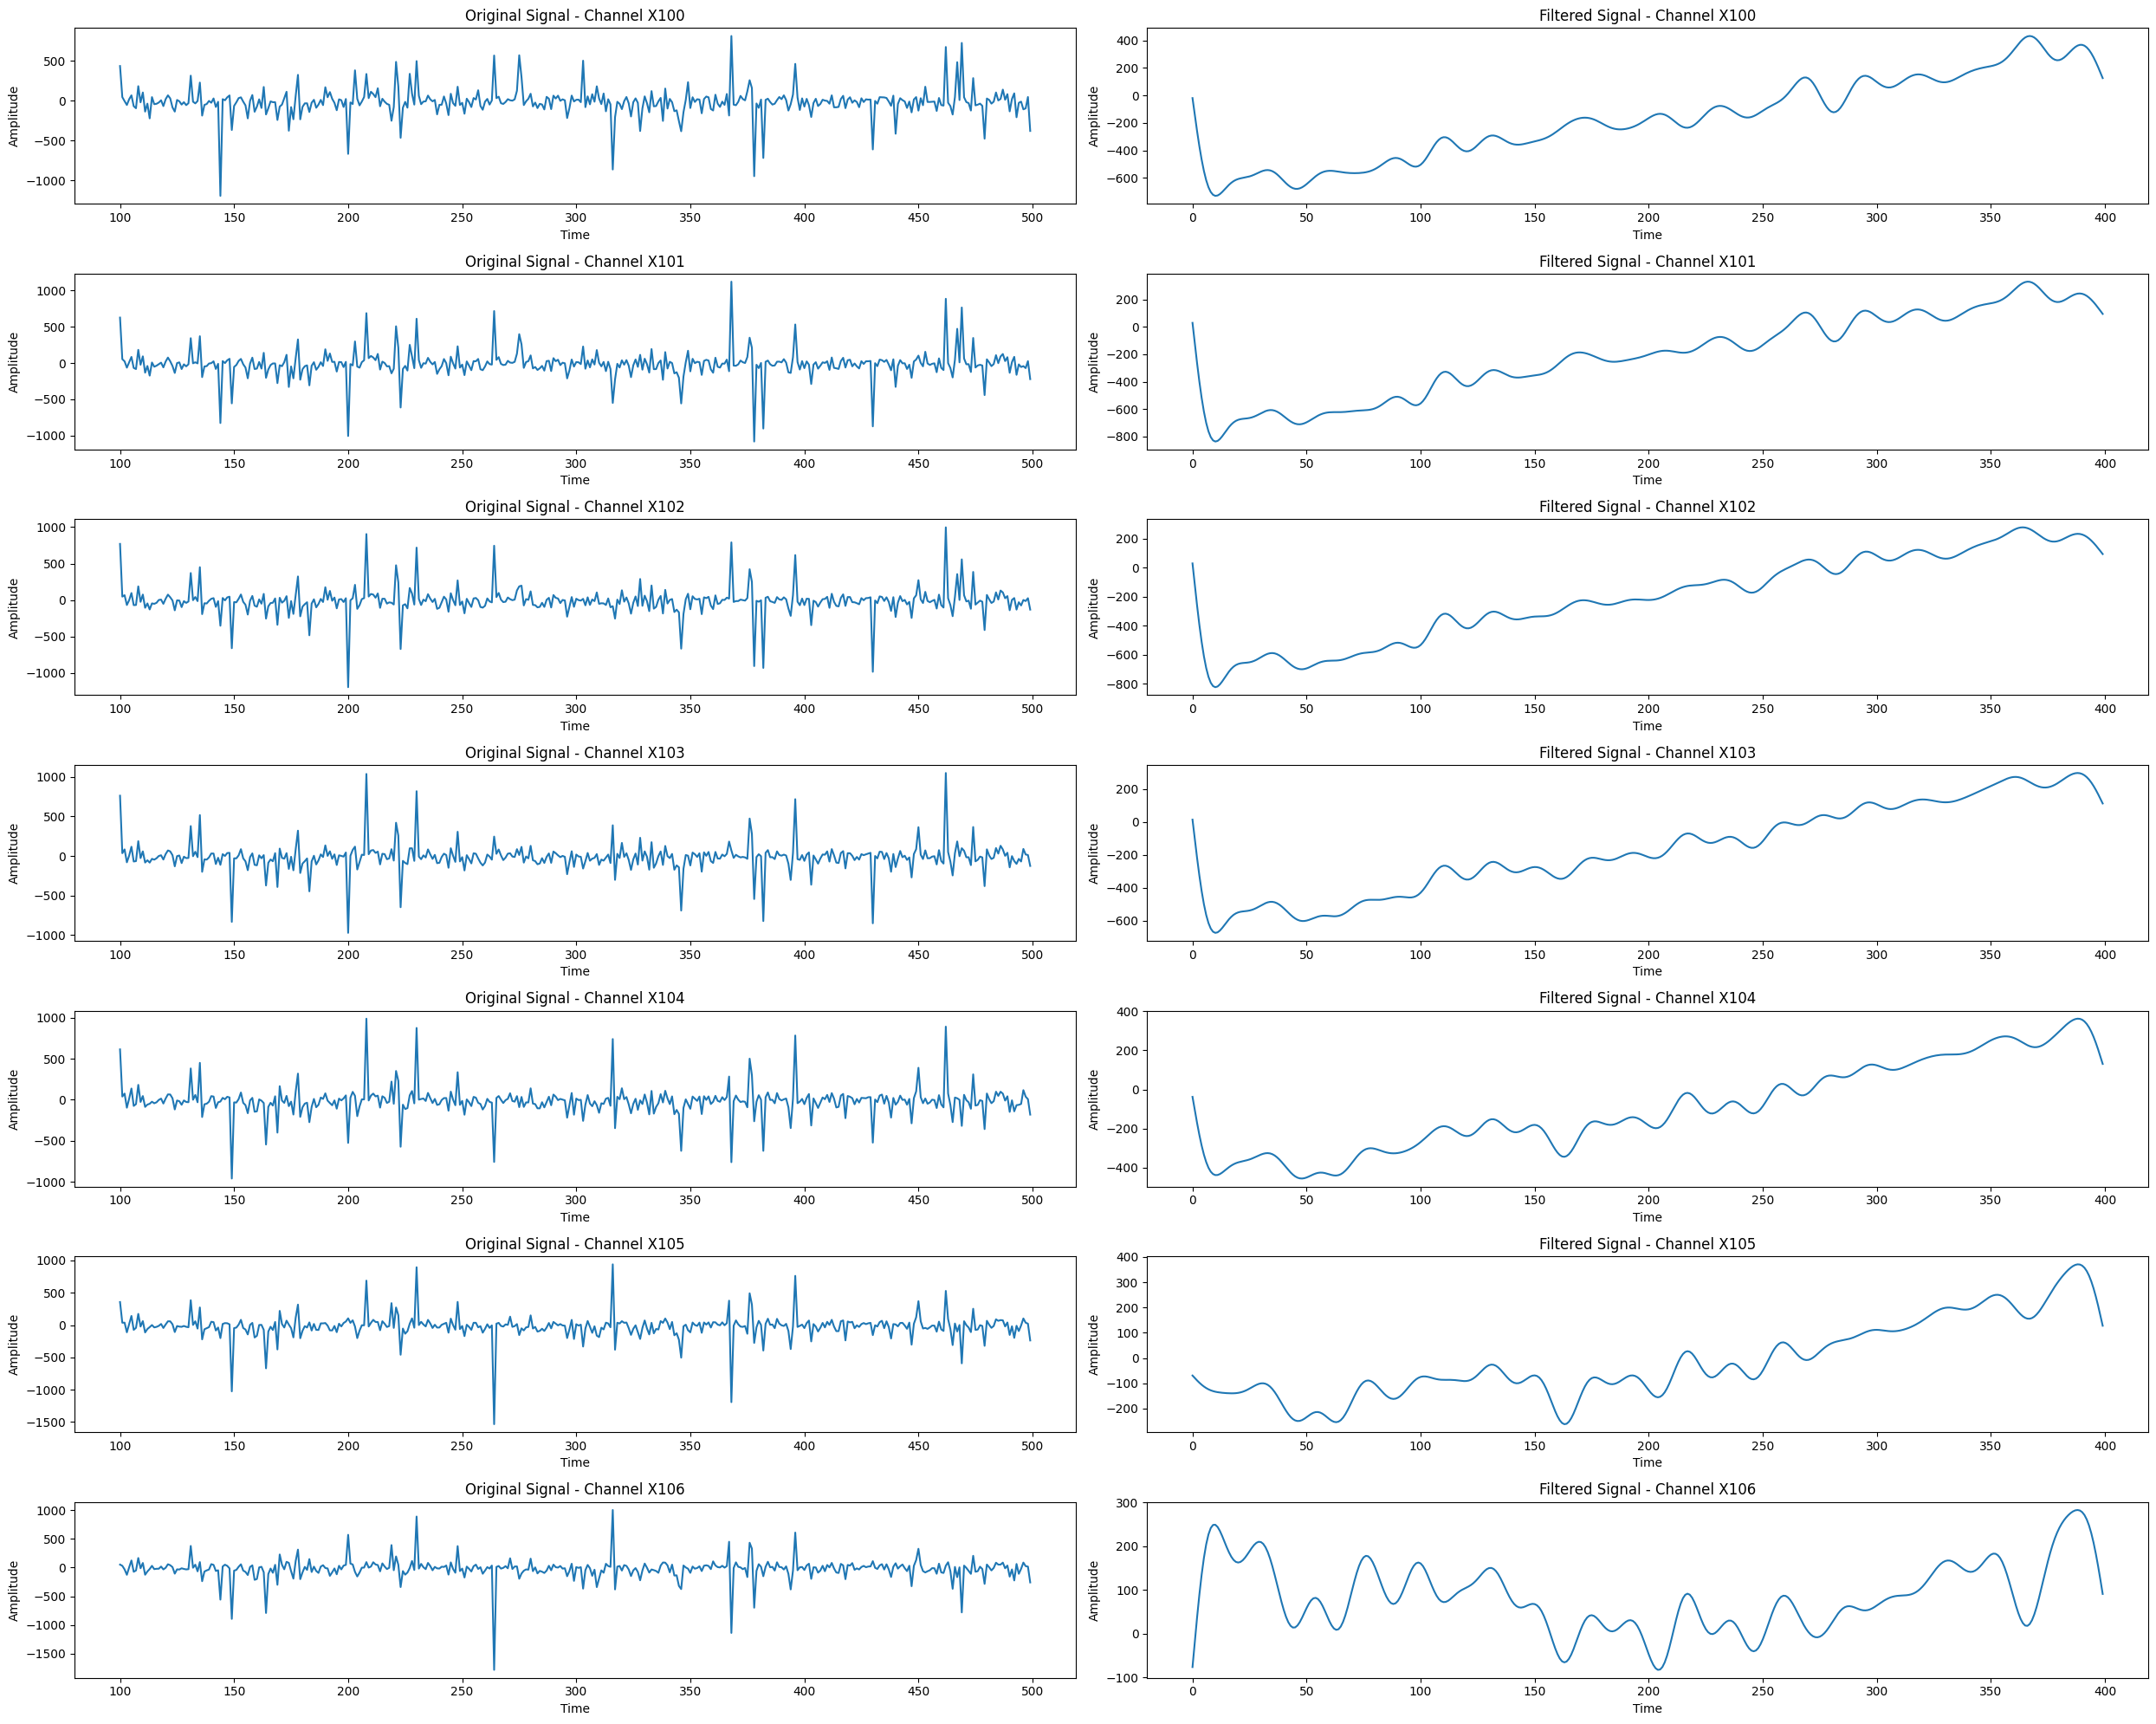

Seizure detected.


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import butter, filtfilt
from scipy.stats import kurtosis, skew
from scipy.signal import welch
import skfuzzy as fuzz
import seaborn as sns
import matplotlib.pyplot as plt

# Load EEG signal dataset
def load_data(filename):
    start_time = time.time()
    eeg_dat = pd.read_csv(filename)  # Load data from CSV file
    eeg_data = eeg_dat.iloc[100:500, 100:180]
    end_time = time.time()
    print(f"Data loading time: {end_time - start_time} seconds")
    return eeg_data

# Define bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply bandpass filter to each channel and create filtered_signal columns
def preprocess_data(data):
    start_time = time.time()
    original_signals = data.copy()
    filtered_signals = {}
    for i, col in enumerate(data.columns[1:], 1):
        filtered_signals[f'filtered_signal_{i}'] = bandpass_filter(data[col], lowcut=0.5, highcut=50, fs=1000)
    end_time = time.time()
    print(f"Data preprocessing time: {end_time - start_time} seconds")
    return original_signals, pd.DataFrame(filtered_signals)

# Function to extract time domain features from a signal
def extract_time_domain_features(signal):
    features = {}
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['max'] = np.max(signal)
    features['min'] = np.min(signal)
    features['median'] = np.median(signal)
    features['kurtosis'] = kurtosis(signal)
    features['skewness'] = skew(signal)
    return features

# Function to extract frequency domain features from a signal
def extract_frequency_domain_features(signal, fs):
    f, Pxx = welch(signal, fs)
    features = {}
    features['spectral_centroid'] = np.sum(f * Pxx) / np.sum(Pxx)
    features['spectral_entropy'] = -np.sum(Pxx * np.log2(Pxx))
    features['total_power'] = np.sum(Pxx)
    return features

# Extract features from each filtered channel
def extract_features(filtered_signals):
    extracted_features = {}
    for i, (col, signal) in enumerate(filtered_signals.items(), 1):
        time_features = extract_time_domain_features(signal)
        frequency_features = extract_frequency_domain_features(signal, fs=1000)
        features = {**time_features, **frequency_features}
        extracted_features[f'channel_{i}'] = features
    return pd.DataFrame(extracted_features).T

# Perform Fuzzy C-Means clustering on the extracted features
def perform_clustering(X, num_clusters):
    cntr, _, _, _, _, _, _ = fuzz.cluster.cmeans(
        X.T, num_clusters, 2, error=0.005, maxiter=1000)
    return cntr

# Assign data points to clusters based on fuzzy clustering centers
num_clusters = 2
def assign_to_clusters(X, cntr):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X.T, num_clusters, 2, error=0.005, maxiter=1000)
    return np.argmax(u, axis=0)

# Train KNN model
def train_knn(X_train, y_train, n_neighbors=5):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    return knn_model

# Main function
def main():
    # Load data
    eeg_data = load_data('/content/seizure_kaggle.csv')

    # Preprocess data (filtering)
    original_signals, filtered_signals = preprocess_data(eeg_data)

    # Extract features
    X = extract_features(filtered_signals)

    # Perform clustering
    cntr = perform_clustering(X, num_clusters)

    # Assign data points to clusters
    y_clusters = assign_to_clusters(X, cntr)

    # Train KNN model on cluster assignments
    X_train, X_test, y_train, y_test = train_test_split(X, y_clusters, test_size=0.5, random_state=42)
    knn_model = train_knn(X_train, y_train)

    # Evaluate model
    print("Test Set Performance:")
    y_pred = knn_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
    print("Confusion Matrix:\n", confusion_matrix)

    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot original and filtered signals for the first three channels
    num_channels_to_plot = 7
    channels_to_plot = original_signals.columns[:num_channels_to_plot]
    plt.figure(figsize=(25, 20))
    for i, channel in enumerate(channels_to_plot, 1):
        plt.subplot(num_channels_to_plot, 2, 2*i-1)
        plt.plot(original_signals[channel])
        plt.title(f'Original Signal - Channel {channel}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        plt.subplot(num_channels_to_plot, 2, 2*i)
        plt.plot(filtered_signals[f'filtered_signal_{i}'])
        plt.title(f'Filtered Signal - Channel {channel}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

    # Predict cluster assignments for test set features
    y_pred_clusters = knn_model.predict(X_test)

    # Define decision rule (example: majority vote)
    # Assuming cluster 0 represents non-seizure and cluster 1 represents seizure
    seizure_detected = (y_pred_clusters == 1).any()

    # Print result
    if seizure_detected:
        print("Seizure detected.")
    else:
        print("No seizure detected.")
if __name__ == "__main__":
    main()
